In [ ]:
#Code taken and modified from https://github.com/SullyChen/Molecular-Solubility-with-PyTorch-Geometric/blob/main/Molecular%20Solubility.ipynb

In [ ]:
!pip install pysmiles
!pip install torch_geometric
import numpy as np
import random
import matplotlib.pyplot as plt
from pysmiles import read_smiles
import pandas as pd
import logging
from tqdm import tqdm
import torch
from torch.nn import Sequential as Seq, Linear, ReLU, CrossEntropyLoss
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, GCNConv
from torch_geometric.utils import remove_self_loops, add_self_loops, degree
from torch_geometric.data import Data

logging.getLogger('pysmiles').setLevel(logging.CRITICAL)  # Anything higher than warning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
with open('/content/drive/MyDrive/SolPred/curated-solubility-dataset.csv', 'r') as f:
  df = pd.read_csv(f) #read dataset (https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/OVHAW8)
X_smiles = list(df['SMILES']) #get smiles strings from file
Y = np.asarray(df['Solubility']) #get solubility values from file
X_data = np.stack((np.asarray(df['MolWt']),np.asarray(df['MolLogP']),np.asarray(df['MolMR']),np.asarray(df['HeavyAtomCount']),np.asarray(df['NumHAcceptors']),np.asarray(df['NumHDonors']),np.asarray(df['NumHeteroatoms']),np.asarray(df['NumRotatableBonds']),np.asarray(df['NumValenceElectrons']),np.asarray(df['NumAromaticRings']),np.asarray(df['NumSaturatedRings']),np.asarray(df['NumAliphaticRings']),np.asarray(df['RingCount']),np.asarray(df['TPSA']),np.asarray(df['LabuteASA']),np.asarray(df['BalabanJ']),np.asarray(df['BertzCT'])),axis=0).T
print(X_data.shape)

X_data_mean = np.mean(X_data,0)
print(X_data_mean.shape)

X_data_std = np.std(X_data,0)

X_data = (X_data-X_data_mean)/X_data_std

elements = ['K', 'Y', 'V', 'Sm', 'Dy', 'In', 'Lu', 'Hg', 'Co', 'Mg',    #list of all elements in the dataset
            'Cu', 'Rh', 'Hf', 'O', 'As', 'Ge', 'Au', 'Mo', 'Br', 'Ce',
            'Zr', 'Ag', 'Ba', 'N', 'Cr', 'Sr', 'Fe', 'Gd', 'I', 'Al',
            'B', 'Se', 'Pr', 'Te', 'Cd', 'Pd', 'Si', 'Zn', 'Pb', 'Sn',
            'Cl', 'Mn', 'Cs', 'Na', 'S', 'Ti', 'Ni', 'Ru', 'Ca', 'Nd',
            'W', 'H', 'Li', 'Sb', 'Bi', 'La', 'Pt', 'Nb', 'P', 'F', 'C']

#convert element to a one-hot vector of dimension len(elements)
def element_to_onehot(element):
    out = []
    for i in range(0, len(element)):
        v = np.zeros(len(elements))
        v[elements.index(element[i])] = 1.0
        out.append(v)
    return np.asarray(out)

#convert solubility value to one-hot class vector
def val_to_class(val):
    if val < -3.65: #insoluble
        return [1, 0, 0]
    elif val < -1.69: #slightly soluble
        return [0, 1, 0]
    else: #soluble
        return [0, 0, 1]

#process SMILES strings into graphs
nodes = []
edge_index = []
for smiles in tqdm(X_smiles):
    try:
        G = read_smiles(smiles, explicit_hydrogen=True)
        feature = element_to_onehot(np.asarray(G.nodes(data='element'))[:, 1])
        edges = np.asarray(G.edges)
        index = np.asarray([edges[:,0], edges[:,1]]) #reshape indices into shape [2, -1]
        nodes.append(feature)
        edge_index.append(index)
    except:
        pass

Mounted at /content/drive/
(9982, 17)
(17,)


100%|██████████| 9982/9982 [00:11<00:00, 888.96it/s]


In [ ]:
#Generate Data objects
data = list()

#process graphs into torch_geometric Data objects
for i in tqdm(range(0, len(nodes))):
    x = torch.tensor(nodes[i], dtype=torch.float) #convert node features into torch tensor
    edges = torch.tensor(edge_index[i], dtype=torch.long) #convert edge index into torch tensor
    y = torch.tensor([val_to_class(Y[i])], dtype=torch.float) #change shape of label and convert to tensor
    data.append((Data(x=x,edge_index=edges, y=y),torch.from_numpy(X_data[i].astype(np.float32)))) #add the Data object to the list of data
random.shuffle(data)
train = data[:int(len(data)*0.8)] #train set
test = data[int(len(data)*0.8):] #val set

100%|██████████| 9947/9947 [00:01<00:00, 5243.77it/s]


In [ ]:
#define the message passing network
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(61, 45)
        self.conv2 = GCNConv(45, 32)
        self.lin1 = Linear(32+17, 64)
        self.lin2 = Linear(64, 32)
        self.lin3 = Linear(32, 16)

        self.lin4 = Linear(16, 3)



    def forward(self, gdata, ldata):
        x, edge_index= gdata.x, gdata.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)


        x = torch.sum(x, dim=0)
        x = torch.cat((x,ldata),axis=0)

        x = self.lin1(x)
        x = F.relu(x)

        x = self.lin2(x)
        x = F.relu(x)

        x = self.lin3(x)
        x = F.relu(x)

        x = self.lin4(x)
        return x

In [ ]:
#set up device and create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #use CUDA if available
model = Net().to(device) #create network and send to the device memory
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) #use Adam optimizer
CSE = CrossEntropyLoss() #define loss

In [ ]:
#train model
model.train() #set model to training mode
for epoch in range(100): #run for epochs of training
    sum_loss = 0 #used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train) #shuffle the training data each epoch
    for d in tqdm(train): #go over each training point
        data = d[0].to(device) #send data to device
        optimizer.zero_grad() #zero gradients
        out = model(data, d[1]) #evaluate data point
        if torch.argmax(out) == torch.argmax(data.y): #if prediction is correct, increment counter for accuracy calculation
            num_correct += 1
        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y),[1])) #compute mean squared error loss
        sum_loss += float(loss) #add loss value to aggregate loss
        loss.backward() #compute gradients
        optimizer.step() #apply optimization
    print('Epoch: {:03d}, Average loss: {:.5f}, Accuracy: {:.5f}'.format(epoch, sum_loss/len(train), num_correct/len(train)))

100%|██████████| 7957/7957 [00:50<00:00, 156.20it/s]


Epoch: 000, Average loss: 0.73745, Accuracy: 0.67136


100%|██████████| 7957/7957 [00:32<00:00, 243.11it/s]


Epoch: 001, Average loss: 0.64666, Accuracy: 0.72565


100%|██████████| 7957/7957 [00:33<00:00, 235.68it/s]


Epoch: 002, Average loss: 0.61985, Accuracy: 0.73872


100%|██████████| 7957/7957 [00:36<00:00, 219.30it/s]


Epoch: 003, Average loss: 0.60554, Accuracy: 0.74425


100%|██████████| 7957/7957 [00:33<00:00, 236.44it/s]


Epoch: 004, Average loss: 0.59778, Accuracy: 0.74174


100%|██████████| 7957/7957 [00:34<00:00, 230.19it/s]


Epoch: 005, Average loss: 0.59054, Accuracy: 0.74438


100%|██████████| 7957/7957 [00:37<00:00, 214.19it/s]


Epoch: 006, Average loss: 0.57895, Accuracy: 0.75355


100%|██████████| 7957/7957 [00:35<00:00, 224.13it/s]


Epoch: 007, Average loss: 0.58052, Accuracy: 0.75619


100%|██████████| 7957/7957 [00:36<00:00, 219.28it/s]


Epoch: 008, Average loss: 0.57131, Accuracy: 0.75405


100%|██████████| 7957/7957 [00:37<00:00, 214.64it/s]


Epoch: 009, Average loss: 0.56658, Accuracy: 0.75745


100%|██████████| 7957/7957 [00:38<00:00, 204.31it/s]


Epoch: 010, Average loss: 0.56244, Accuracy: 0.76247


100%|██████████| 7957/7957 [00:37<00:00, 209.48it/s]


Epoch: 011, Average loss: 0.56037, Accuracy: 0.76272


100%|██████████| 7957/7957 [00:37<00:00, 214.93it/s]


Epoch: 012, Average loss: 0.55974, Accuracy: 0.76059


100%|██████████| 7957/7957 [00:38<00:00, 206.52it/s]


Epoch: 013, Average loss: 0.55336, Accuracy: 0.76210


100%|██████████| 7957/7957 [00:36<00:00, 215.44it/s]


Epoch: 014, Average loss: 0.54568, Accuracy: 0.76813


100%|██████████| 7957/7957 [00:39<00:00, 202.10it/s]


Epoch: 015, Average loss: 0.54501, Accuracy: 0.76800


100%|██████████| 7957/7957 [00:37<00:00, 212.44it/s]


Epoch: 016, Average loss: 0.54203, Accuracy: 0.76775


100%|██████████| 7957/7957 [00:37<00:00, 212.80it/s]


Epoch: 017, Average loss: 0.53522, Accuracy: 0.77454


100%|██████████| 7957/7957 [00:35<00:00, 225.46it/s]


Epoch: 018, Average loss: 0.53481, Accuracy: 0.77554


100%|██████████| 7957/7957 [00:36<00:00, 219.61it/s]


Epoch: 019, Average loss: 0.53020, Accuracy: 0.77492


100%|██████████| 7957/7957 [00:37<00:00, 214.92it/s]


Epoch: 020, Average loss: 0.52561, Accuracy: 0.77793


100%|██████████| 7957/7957 [00:36<00:00, 216.66it/s]


Epoch: 021, Average loss: 0.52570, Accuracy: 0.77969


100%|██████████| 7957/7957 [00:37<00:00, 214.26it/s]


Epoch: 022, Average loss: 0.52316, Accuracy: 0.77655


100%|██████████| 7957/7957 [00:38<00:00, 206.18it/s]


Epoch: 023, Average loss: 0.52108, Accuracy: 0.77869


100%|██████████| 7957/7957 [00:38<00:00, 205.91it/s]


Epoch: 024, Average loss: 0.51635, Accuracy: 0.78522


100%|██████████| 7957/7957 [00:36<00:00, 220.12it/s]


Epoch: 025, Average loss: 0.51644, Accuracy: 0.78032


100%|██████████| 7957/7957 [00:36<00:00, 219.11it/s]


Epoch: 026, Average loss: 0.51006, Accuracy: 0.78509


100%|██████████| 7957/7957 [00:34<00:00, 227.43it/s]


Epoch: 027, Average loss: 0.51000, Accuracy: 0.78346


100%|██████████| 7957/7957 [00:34<00:00, 229.06it/s]


Epoch: 028, Average loss: 0.50821, Accuracy: 0.78283


100%|██████████| 7957/7957 [00:35<00:00, 221.86it/s]


Epoch: 029, Average loss: 0.50485, Accuracy: 0.78560


100%|██████████| 7957/7957 [00:33<00:00, 235.46it/s]


Epoch: 030, Average loss: 0.50512, Accuracy: 0.78409


100%|██████████| 7957/7957 [00:34<00:00, 233.20it/s]


Epoch: 031, Average loss: 0.50648, Accuracy: 0.78409


100%|██████████| 7957/7957 [00:34<00:00, 228.43it/s]


Epoch: 032, Average loss: 0.50072, Accuracy: 0.78635


100%|██████████| 7957/7957 [00:34<00:00, 227.51it/s]


Epoch: 033, Average loss: 0.49703, Accuracy: 0.78660


100%|██████████| 7957/7957 [00:35<00:00, 225.92it/s]


Epoch: 034, Average loss: 0.49952, Accuracy: 0.78937


100%|██████████| 7957/7957 [00:35<00:00, 226.67it/s]


Epoch: 035, Average loss: 0.49702, Accuracy: 0.79138


100%|██████████| 7957/7957 [00:34<00:00, 228.13it/s]


Epoch: 036, Average loss: 0.48900, Accuracy: 0.79125


100%|██████████| 7957/7957 [00:34<00:00, 228.73it/s]


Epoch: 037, Average loss: 0.49113, Accuracy: 0.79565


100%|██████████| 7957/7957 [00:37<00:00, 212.56it/s]


Epoch: 038, Average loss: 0.49281, Accuracy: 0.79389


100%|██████████| 7957/7957 [00:35<00:00, 227.30it/s]


Epoch: 039, Average loss: 0.48178, Accuracy: 0.79465


100%|██████████| 7957/7957 [00:35<00:00, 226.83it/s]


Epoch: 040, Average loss: 0.48601, Accuracy: 0.80005


100%|██████████| 7957/7957 [00:35<00:00, 221.56it/s]


Epoch: 041, Average loss: 0.48568, Accuracy: 0.79666


100%|██████████| 7957/7957 [00:35<00:00, 225.42it/s]


Epoch: 042, Average loss: 0.48254, Accuracy: 0.79729


100%|██████████| 7957/7957 [00:34<00:00, 233.00it/s]


Epoch: 043, Average loss: 0.47952, Accuracy: 0.79904


100%|██████████| 7957/7957 [00:36<00:00, 218.04it/s]


Epoch: 044, Average loss: 0.47839, Accuracy: 0.79967


100%|██████████| 7957/7957 [00:34<00:00, 233.44it/s]


Epoch: 045, Average loss: 0.47915, Accuracy: 0.80030


100%|██████████| 7957/7957 [00:34<00:00, 232.31it/s]


Epoch: 046, Average loss: 0.48443, Accuracy: 0.79666


100%|██████████| 7957/7957 [00:35<00:00, 227.00it/s]


Epoch: 047, Average loss: 0.47203, Accuracy: 0.80520


100%|██████████| 7957/7957 [00:35<00:00, 226.43it/s]


Epoch: 048, Average loss: 0.47373, Accuracy: 0.80721


100%|██████████| 7957/7957 [00:35<00:00, 225.81it/s]


Epoch: 049, Average loss: 0.47170, Accuracy: 0.80407


100%|██████████| 7957/7957 [00:35<00:00, 222.93it/s]


Epoch: 050, Average loss: 0.46910, Accuracy: 0.80181


100%|██████████| 7957/7957 [00:35<00:00, 223.70it/s]


Epoch: 051, Average loss: 0.46615, Accuracy: 0.80319


100%|██████████| 7957/7957 [00:36<00:00, 216.63it/s]


Epoch: 052, Average loss: 0.46733, Accuracy: 0.80922


100%|██████████| 7957/7957 [00:35<00:00, 222.26it/s]


Epoch: 053, Average loss: 0.46304, Accuracy: 0.80407


100%|██████████| 7957/7957 [00:34<00:00, 231.07it/s]


Epoch: 054, Average loss: 0.46334, Accuracy: 0.80596


100%|██████████| 7957/7957 [00:35<00:00, 226.71it/s]


Epoch: 055, Average loss: 0.46295, Accuracy: 0.80897


100%|██████████| 7957/7957 [00:37<00:00, 211.11it/s]


Epoch: 056, Average loss: 0.45366, Accuracy: 0.80910


100%|██████████| 7957/7957 [00:36<00:00, 220.94it/s]


Epoch: 057, Average loss: 0.45601, Accuracy: 0.81161


100%|██████████| 7957/7957 [00:38<00:00, 208.70it/s]


Epoch: 058, Average loss: 0.45782, Accuracy: 0.81174


100%|██████████| 7957/7957 [00:36<00:00, 215.10it/s]


Epoch: 059, Average loss: 0.45463, Accuracy: 0.81036


100%|██████████| 7957/7957 [00:35<00:00, 224.77it/s]


Epoch: 060, Average loss: 0.45371, Accuracy: 0.81325


100%|██████████| 7957/7957 [00:34<00:00, 229.71it/s]


Epoch: 061, Average loss: 0.45556, Accuracy: 0.81086


100%|██████████| 7957/7957 [00:34<00:00, 230.18it/s]


Epoch: 062, Average loss: 0.45484, Accuracy: 0.81212


100%|██████████| 7957/7957 [00:35<00:00, 225.70it/s]


Epoch: 063, Average loss: 0.45005, Accuracy: 0.81400


100%|██████████| 7957/7957 [00:35<00:00, 226.59it/s]


Epoch: 064, Average loss: 0.45063, Accuracy: 0.81375


100%|██████████| 7957/7957 [00:34<00:00, 230.37it/s]


Epoch: 065, Average loss: 0.44689, Accuracy: 0.81463


100%|██████████| 7957/7957 [00:34<00:00, 227.56it/s]


Epoch: 066, Average loss: 0.44892, Accuracy: 0.81299


100%|██████████| 7957/7957 [00:37<00:00, 210.54it/s]


Epoch: 067, Average loss: 0.44555, Accuracy: 0.81526


100%|██████████| 7957/7957 [00:34<00:00, 227.57it/s]


Epoch: 068, Average loss: 0.44584, Accuracy: 0.81488


100%|██████████| 7957/7957 [00:34<00:00, 230.78it/s]


Epoch: 069, Average loss: 0.44713, Accuracy: 0.81287


100%|██████████| 7957/7957 [00:35<00:00, 221.85it/s]


Epoch: 070, Average loss: 0.44631, Accuracy: 0.81475


100%|██████████| 7957/7957 [00:34<00:00, 228.22it/s]


Epoch: 071, Average loss: 0.43819, Accuracy: 0.81563


100%|██████████| 7957/7957 [00:34<00:00, 227.71it/s]


Epoch: 072, Average loss: 0.44476, Accuracy: 0.81287


100%|██████████| 7957/7957 [00:35<00:00, 222.56it/s]


Epoch: 073, Average loss: 0.44201, Accuracy: 0.81463


100%|██████████| 7957/7957 [00:34<00:00, 231.26it/s]


Epoch: 074, Average loss: 0.44148, Accuracy: 0.81714


100%|██████████| 7957/7957 [00:35<00:00, 227.07it/s]


Epoch: 075, Average loss: 0.44303, Accuracy: 0.81325


100%|██████████| 7957/7957 [00:35<00:00, 223.80it/s]


Epoch: 076, Average loss: 0.43938, Accuracy: 0.81840


100%|██████████| 7957/7957 [00:37<00:00, 213.39it/s]


Epoch: 077, Average loss: 0.43853, Accuracy: 0.82028


100%|██████████| 7957/7957 [00:34<00:00, 231.50it/s]


Epoch: 078, Average loss: 0.44332, Accuracy: 0.81463


100%|██████████| 7957/7957 [00:35<00:00, 226.23it/s]


Epoch: 079, Average loss: 0.43881, Accuracy: 0.81651


100%|██████████| 7957/7957 [00:34<00:00, 229.96it/s]


Epoch: 080, Average loss: 0.43785, Accuracy: 0.81777


100%|██████████| 7957/7957 [00:34<00:00, 233.98it/s]


Epoch: 081, Average loss: 0.43452, Accuracy: 0.81915


100%|██████████| 7957/7957 [00:35<00:00, 223.82it/s]


Epoch: 082, Average loss: 0.43605, Accuracy: 0.81840


100%|██████████| 7957/7957 [00:35<00:00, 221.17it/s]


Epoch: 083, Average loss: 0.42898, Accuracy: 0.82242


100%|██████████| 7957/7957 [00:34<00:00, 231.03it/s]


Epoch: 084, Average loss: 0.43633, Accuracy: 0.82116


100%|██████████| 7957/7957 [00:34<00:00, 228.78it/s]


Epoch: 085, Average loss: 0.43241, Accuracy: 0.82418


100%|██████████| 7957/7957 [00:35<00:00, 226.37it/s]


Epoch: 086, Average loss: 0.42865, Accuracy: 0.81915


100%|██████████| 7957/7957 [00:34<00:00, 232.26it/s]


Epoch: 087, Average loss: 0.43606, Accuracy: 0.81940


100%|██████████| 7957/7957 [00:34<00:00, 231.61it/s]


Epoch: 088, Average loss: 0.43271, Accuracy: 0.82129


100%|██████████| 7957/7957 [00:35<00:00, 221.82it/s]


Epoch: 089, Average loss: 0.42567, Accuracy: 0.82317


100%|██████████| 7957/7957 [00:34<00:00, 231.12it/s]


Epoch: 090, Average loss: 0.43237, Accuracy: 0.81790


100%|██████████| 7957/7957 [00:34<00:00, 233.14it/s]


Epoch: 091, Average loss: 0.43001, Accuracy: 0.82355


100%|██████████| 7957/7957 [00:36<00:00, 216.60it/s]


Epoch: 092, Average loss: 0.42179, Accuracy: 0.82519


100%|██████████| 7957/7957 [00:35<00:00, 223.87it/s]


Epoch: 093, Average loss: 0.42973, Accuracy: 0.82204


100%|██████████| 7957/7957 [00:35<00:00, 227.34it/s]


Epoch: 094, Average loss: 0.42276, Accuracy: 0.82808


100%|██████████| 7957/7957 [00:35<00:00, 222.88it/s]


Epoch: 095, Average loss: 0.42090, Accuracy: 0.82343


100%|██████████| 7957/7957 [00:35<00:00, 226.91it/s]


Epoch: 096, Average loss: 0.42634, Accuracy: 0.82355


100%|██████████| 7957/7957 [00:34<00:00, 231.76it/s]


Epoch: 097, Average loss: 0.42071, Accuracy: 0.82883


100%|██████████| 7957/7957 [00:35<00:00, 225.39it/s]


Epoch: 098, Average loss: 0.42730, Accuracy: 0.82506


100%|██████████| 7957/7957 [00:35<00:00, 225.70it/s]

Epoch: 099, Average loss: 0.42231, Accuracy: 0.82757


100%|██████████| 1990/1990 [00:02<00:00, 667.10it/s]


Test accuracy: 0.7698492462311558


(array([624., 694., 672.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

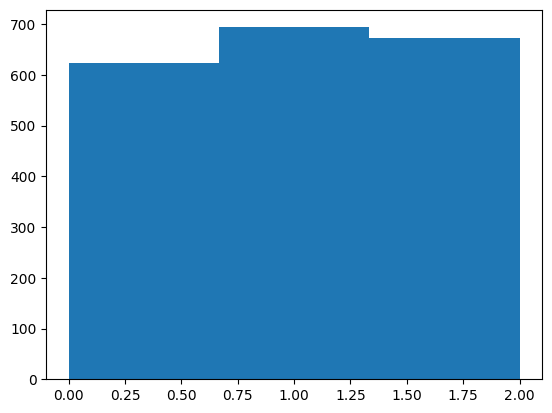

In [ ]:
#test the model and display a histogram of the outputs
num_correct = 0
model.eval()
predictions = list()
y_pred = list()
y_true = list()
for t in tqdm(test):
    d = t[0].to(device)
    out = model(d,t[1])
    y_true.append(torch.argmax(d.y))
    y_pred.append(torch.argmax(out))
    if torch.argmax(out) == torch.argmax(d.y): #if prediction is correct, increment counter for accuracy calculation
            num_correct += 1
    predictions.append(torch.argmax(out).item())

print("Test accuracy: " + str(num_correct/len(test)))
plt.hist(predictions, bins=3)

[tensor(2), tensor(2), tensor(2), tensor(2), tensor(1), tensor(0), tensor(2), tensor(0), tensor(0), tensor(2), tensor(0), tensor(1), tensor(2), tensor(2), tensor(1), tensor(2), tensor(1), tensor(2), tensor(1), tensor(0), tensor(1), tensor(0), tensor(2), tensor(1), tensor(1), tensor(0), tensor(0), tensor(1), tensor(2), tensor(2), tensor(1), tensor(0), tensor(1), tensor(2), tensor(0), tensor(1), tensor(0), tensor(2), tensor(0), tensor(2), tensor(0), tensor(0), tensor(0), tensor(1), tensor(1), tensor(0), tensor(2), tensor(1), tensor(0), tensor(2), tensor(1), tensor(1), tensor(1), tensor(1), tensor(2), tensor(2), tensor(1), tensor(1), tensor(1), tensor(2), tensor(2), tensor(1), tensor(1), tensor(1), tensor(2), tensor(0), tensor(0), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(1), tensor(2), tensor(0), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(1), tensor(0), tensor(0), tensor(1), tensor(1), tensor(2), tensor(2), tensor(1), tensor(2), tensor(2), tensor(1)

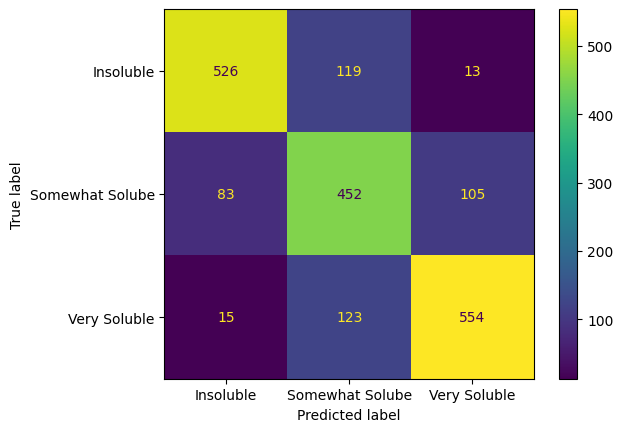

In [ ]:
import sklearn
from sklearn import metrics
print(y_pred)
cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Insoluble", "Somewhat Solube", "Very Soluble"])

import matplotlib.pyplot as plt

cm_display.plot()
plt.show()




